In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks

# Load the CSV file 
# Replace 'your_file.csv' with your CSV filename.
# Make sure your file has a 'date' and 'value' column.
data = pl.read_csv(
    "JRF for forecasting model.csv",
    try_parse_dates=True,
    infer_schema_length=10000,   # read more rows to infer column types
    null_values=["NULL", "N/A", ""],  # interpret these as null
    ignore_errors=True            # skip lines with parsing issues
)

# Inspect and prepare the data
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].head(10))

# Check data type of column
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].dtypes)

shape: (10, 8)
┌──────┬────────────────┬────────────────┬─────────────┬────────────────┬────────────┬────────────────┬────────────────┐
│ id   ┆ product        ┆ resource_requi ┆ region      ┆ date_requested ┆ start_date ┆ week_yyyy_star ┆ mm_yyyy_start_ │
│ ---  ┆ ---            ┆ red            ┆ ---         ┆ ---            ┆ ---        ┆ t_date         ┆ date           │
│ i64  ┆ str            ┆ ---            ┆ str         ┆ datetime[μs]   ┆ str        ┆ ---            ┆ ---            │
│      ┆                ┆ i64            ┆             ┆                ┆            ┆ str            ┆ str            │
╞══════╪════════════════╪════════════════╪═════════════╪════════════════╪════════════╪════════════════╪════════════════╡
│ 2408 ┆ General        ┆ 1              ┆ Philippines ┆ 2023-02-01     ┆ 01-11-2023 ┆ 01-09-2023     ┆ 2023-01        │
│      ┆ Virtual        ┆                ┆             ┆ 14:38:57       ┆            ┆                ┆                │
│      ┆ Assistan

In [2]:
# Group Start Date, Product and Resource Required

time_series  = (
    data.group_by(["start_date","week_yyyy_start_date","mm_yyyy_start_date"])
        .agg([
            pl.sum("resource_required").alias("Total_HC")
        ])
)

time_series = time_series.drop_nulls()

print(time_series.head(10))

shape: (10, 4)
┌────────────┬──────────────────────┬────────────────────┬──────────┐
│ start_date ┆ week_yyyy_start_date ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---        ┆ ---                  ┆ ---                ┆ ---      │
│ str        ┆ str                  ┆ str                ┆ i64      │
╞════════════╪══════════════════════╪════════════════════╪══════════╡
│ 06-06-2024 ┆ 06-03-2024           ┆ 2024-06            ┆ 11       │
│ 08-17-2023 ┆ 08-14-2023           ┆ 2023-08            ┆ 11       │
│ 07-16-2023 ┆ 07-10-2023           ┆ 2023-07            ┆ 1        │
│ 02-08-2024 ┆ 02-05-2024           ┆ 2024-02            ┆ 7        │
│ 08-12-2024 ┆ 08-12-2024           ┆ 2024-08            ┆ 16       │
│ 12-26-2025 ┆ 12-22-2025           ┆ 2025-12            ┆ 5        │
│ 02-28-2025 ┆ 02-24-2025           ┆ 2025-02            ┆ 16       │
│ 08-01-2025 ┆ 07-28-2025           ┆ 2025-08            ┆ 12       │
│ 04-04-2025 ┆ 03-31-2025           ┆ 2025-04            ┆ 12       │
│ 10-

In [3]:
# --- Ensure 'start_date' is parsed as Datetime safely ---
if time_series.schema['start_date'] == pl.Utf8:
    # Parse day-month-year format like "01-11-2023"
    time_series = time_series.with_columns(
        pl.col('start_date')
        .str.strptime(pl.Datetime, "%m-%d-%Y", strict=False)
    )
else:
    # Already datetime-like — ensure consistent dtype
    time_series = pl.with_columns(pl.col('start_date').cast(pl.Datetime))

# Sort by date
time_series = time_series.sort('start_date')

# Display sample data
print(time_series.head(10))

shape: (10, 4)
┌─────────────────────┬──────────────────────┬────────────────────┬──────────┐
│ start_date          ┆ week_yyyy_start_date ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---                 ┆ ---                  ┆ ---                ┆ ---      │
│ datetime[μs]        ┆ str                  ┆ str                ┆ i64      │
╞═════════════════════╪══════════════════════╪════════════════════╪══════════╡
│ 2023-01-11 00:00:00 ┆ 01-09-2023           ┆ 2023-01            ┆ 1        │
│ 2023-01-12 00:00:00 ┆ 01-09-2023           ┆ 2023-01            ┆ 4        │
│ 2023-01-13 00:00:00 ┆ 01-09-2023           ┆ 2023-01            ┆ 2        │
│ 2023-01-16 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 2        │
│ 2023-01-17 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 4        │
│ 2023-01-18 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 5        │
│ 2023-01-19 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 3        │
│ 2023-01-20 00:00:00 ┆ 01-16-2023   

In [4]:
# --- Convert to daily frequency (manual resampling) ---

# Get min/max as Python datetime objects
min_date = time_series['start_date'].min()
max_date = time_series['start_date'].max()

# Convert to Python datetime if they’re Polars datetimes
if isinstance(min_date, pl.Series):
    min_date = min_date.to_list()[0]
if isinstance(max_date, pl.Series):
    max_date = max_date.to_list()[0]

# Display sample data
print(time_series.dtypes)
print(time_series.head(10))

print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].dtypes)
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].head(10))

[Datetime(time_unit='us', time_zone=None), String, String, Int64]
shape: (10, 4)
┌─────────────────────┬──────────────────────┬────────────────────┬──────────┐
│ start_date          ┆ week_yyyy_start_date ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---                 ┆ ---                  ┆ ---                ┆ ---      │
│ datetime[μs]        ┆ str                  ┆ str                ┆ i64      │
╞═════════════════════╪══════════════════════╪════════════════════╪══════════╡
│ 2023-01-11 00:00:00 ┆ 01-09-2023           ┆ 2023-01            ┆ 1        │
│ 2023-01-12 00:00:00 ┆ 01-09-2023           ┆ 2023-01            ┆ 4        │
│ 2023-01-13 00:00:00 ┆ 01-09-2023           ┆ 2023-01            ┆ 2        │
│ 2023-01-16 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 2        │
│ 2023-01-17 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 4        │
│ 2023-01-18 00:00:00 ┆ 01-16-2023           ┆ 2023-01            ┆ 5        │
│ 2023-01-19 00:00:00 ┆ 01-16-2023           ┆ 202

In [5]:
# --- Ensure 'start_date' is parsed as Datetime safely ---
if data.schema['start_date'] == pl.Utf8:
    # Parse day-month-year format like "01-11-2023"
    data = data.with_columns(
        pl.col('start_date')
        .str.strptime(pl.Datetime, "%m-%d-%Y", strict=False)
    )
else:
    # Already datetime-like — ensure consistent dtype
    data = pl.with_columns(pl.col('start_date').cast(pl.Datetime))

# --- Ensure 'start_date' in data is parsed as Datetime[μs] ---
if data.schema["start_date"] == pl.Utf8:
    # Handle common formats like "01-11-2023" or "2023-01-11"
    data = data.with_columns(
        pl.when(pl.col("start_date").str.contains("-"))
        .then(
            pl.col("start_date").str.strptime(
                pl.Datetime("us"),
                format="%Y-%m-%d",
                strict=False
            )
        )
        .otherwise(
            pl.col("start_date").str.strptime(
                pl.Datetime("us"),
                format="%m-%d-%Y %H:%M:%S",
                strict=False
            )
        )
        .alias("start_date")
    )
else:
    # Already datetime — just ensure precision matches
    data = data.with_columns(pl.col("start_date").cast(pl.Datetime("us")))

# Display sample data
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].dtypes)
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].head(10))

[Int64, String, Int64, String, Datetime(time_unit='us', time_zone=None), Datetime(time_unit='us', time_zone=None), String, String]
shape: (10, 8)
┌──────┬────────────────┬────────────────┬─────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ id   ┆ product        ┆ resource_requi ┆ region      ┆ date_requeste ┆ start_date    ┆ week_yyyy_sta ┆ mm_yyyy_start │
│ ---  ┆ ---            ┆ red            ┆ ---         ┆ d             ┆ ---           ┆ rt_date       ┆ _date         │
│ i64  ┆ str            ┆ ---            ┆ str         ┆ ---           ┆ datetime[μs]  ┆ ---           ┆ ---           │
│      ┆                ┆ i64            ┆             ┆ datetime[μs]  ┆               ┆ str           ┆ str           │
╞══════╪════════════════╪════════════════╪═════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 2408 ┆ General        ┆ 1              ┆ Philippines ┆ 2023-02-01    ┆ 2023-01-11    ┆ 01-09-2023    ┆ 2023-01       │
│      

In [6]:
# --- Generate daily date range as Datetime ---
# 'time_unit' is no longer accepted; cast manually after creation
date_range = (
    pl.date_range(
        start=min_date,
        end=max_date,
        interval="1d",
        eager=True
    )
    .cast(pl.Datetime("us"))  # ensure same precision as start_date
)

# Convert to DataFrame
date_df = pl.DataFrame({"start_date": date_range})

# --- Join with original data to ensure daily continuity ---
data = (
    date_df
    .join(data, on="start_date", how="left")
    .fill_null(strategy="forward")  # optional: fill missing days
)

# Inspect the data
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].head(10))

# Check data type of column
print(data["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].dtypes)

# Check the data
print(date_range.head(10))
#print(date_df["id","product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].head(10))
print(date_df.head(10))

print(time_series.head(10))

shape: (10, 8)
┌──────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ id   ┆ product       ┆ resource_requ ┆ region        ┆ date_requeste ┆ start_date    ┆ week_yyyy_sta ┆ mm_yyyy_start │
│ ---  ┆ ---           ┆ ired          ┆ ---           ┆ d             ┆ ---           ┆ rt_date       ┆ _date         │
│ i64  ┆ str           ┆ ---           ┆ str           ┆ ---           ┆ datetime[μs]  ┆ ---           ┆ ---           │
│      ┆               ┆ i64           ┆               ┆ datetime[μs]  ┆               ┆ str           ┆ str           │
╞══════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 2408 ┆ General       ┆ 1             ┆ Philippines   ┆ 2023-02-01    ┆ 2023-01-11    ┆ 01-09-2023    ┆ 2023-01       │
│      ┆ Virtual       ┆               ┆               ┆ 14:38:57      ┆ 00:00:00      ┆               ┆               │
│      ┆ Assistan

In [7]:
# Save Time Series to CSV
# time_series_df = pl.DataFrame({
#     'Start Date': time_series['start_date'],
#     'Actual HC': time_series['Total_HC']
# })

# Create Polars DataFrame and format Start Date
time_series_df = (
    pl.DataFrame({
        "Start Date": time_series["start_date"],
        "Actual HC": time_series["Total_HC"]
    })
    .with_columns(
        pl.col("Start Date")
        .dt.strftime("%m/%d/%Y")   # format as MM/DD/YYYY
    )
)


print(time_series_df.head(10))

# Save to CSV
time_series_df.write_csv('jrf_time_series_output.csv')
print("Time Series saved to 'jrf_time_series_output.csv'")

shape: (10, 2)
┌────────────┬───────────┐
│ Start Date ┆ Actual HC │
│ ---        ┆ ---       │
│ str        ┆ i64       │
╞════════════╪═══════════╡
│ 01/11/2023 ┆ 1         │
│ 01/12/2023 ┆ 4         │
│ 01/13/2023 ┆ 2         │
│ 01/16/2023 ┆ 2         │
│ 01/17/2023 ┆ 4         │
│ 01/18/2023 ┆ 5         │
│ 01/19/2023 ┆ 3         │
│ 01/20/2023 ┆ 8         │
│ 01/23/2023 ┆ 11        │
│ 01/24/2023 ┆ 6         │
└────────────┴───────────┘
Time Series saved to 'jrf_time_series_output.csv'


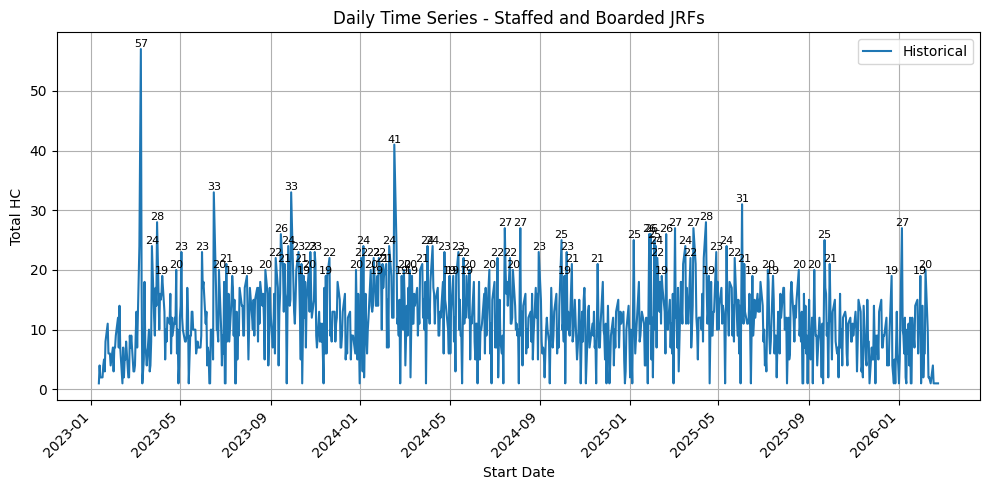

In [8]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series['start_date'], time_series['Total_HC'], label="Historical")

# --- Detect spikes ---
y = time_series['Total_HC'].to_numpy()
x = time_series['start_date'].to_numpy()

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

plt.title("Daily Time Series - Staffed and Boarded JRFs")
plt.xlabel("Start Date")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize the time series - without data labels
# plt.figure(figsize=(10, 5))
# plt.plot(time_series['start_date'], time_series['Total_HC'])
# plt.title("Daily Time Series - Staffed and Boarded JRFs")
# plt.xlabel("Start Date")
# plt.ylabel("Total HC")
# plt.grid(True)
# plt.show()

In [9]:
# Fit the ARIMA model
# Convert to pandas Series with datetime index (required by statsmodels)
ts = (
    time_series.to_pandas()
    .set_index('start_date')['Total_HC']
    .asfreq('D')  # explicitly set daily frequency / W for weekly / M for monthly
)

# Ensure index is sorted and no missing timestamps
ts = ts.sort_index().interpolate()

print(ts.head(10))

start_date
2023-01-11    1.0
2023-01-12    4.0
2023-01-13    2.0
2023-01-14    2.0
2023-01-15    2.0
2023-01-16    2.0
2023-01-17    4.0
2023-01-18    5.0
2023-01-19    3.0
2023-01-20    8.0
Freq: D, Name: Total_HC, dtype: float64


In [10]:
# Fit ARIMA model (p, d, q)
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Total_HC   No. Observations:                 1140
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3576.841
Date:                Fri, 06 Feb 2026   AIC                           7159.683
Time:                        02:36:05   BIC                           7174.796
Sample:                    01-11-2023   HQIC                          7165.391
                         - 02-23-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3179      0.023     14.073      0.000       0.274       0.362
ma.L1         -0.9655      0.008   -114.724      0.000      -0.982      -0.949
sigma2        31.2173      0.917     34.040      0.0

In [11]:
# --- Forecast next N days ---
n_forecast = 90  # you can change this number as needed
forecast_result = model_fit.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


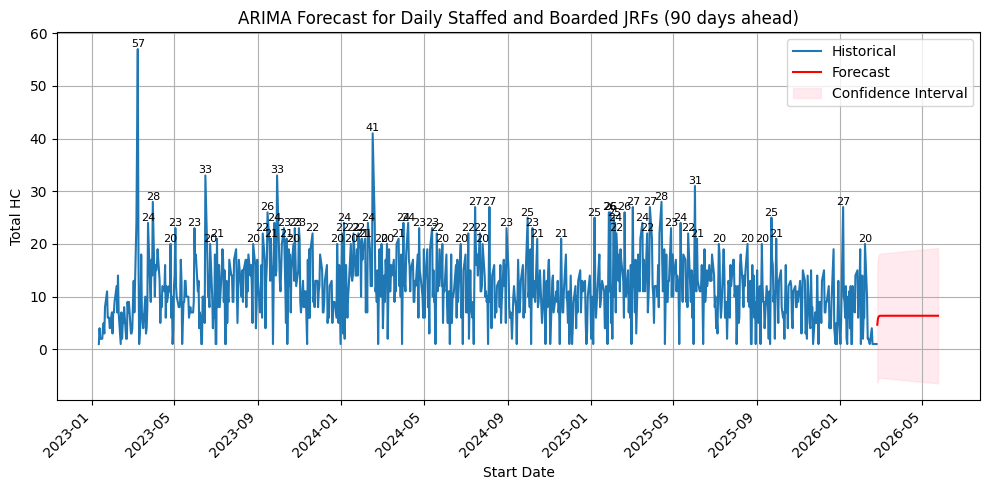

In [12]:
# --- With data labels ---
plt.figure(figsize=(10, 5))

# --- Plot historical & forecast ---
plt.plot(ts.index, ts.values, label='Historical')
plt.plot(forecast.index, forecast.values, color='red', label='Forecast')

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# --- Detect largest spikes in historical data ---
y = ts.values
x = ts.index

# Find peaks
peaks, _ = find_peaks(y)

# Keep only top 10% highest peaks
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for major spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Without data labels ---
# --- Plot actual + forecast ---
# plt.figure(figsize=(10, 5))
# plt.plot(ts, label='Historical')
# plt.plot(forecast.index, forecast, color='red', label='Forecast')
# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],
#     conf_int.iloc[:, 1],
#     color='pink',
#     alpha=0.3,
#     label='Confidence Interval'
# )

# --- Formatting ---
plt.title(f"ARIMA Forecast for Daily Staffed and Boarded JRFs ({n_forecast} days ahead)")
plt.xlabel("Start Date")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Save forecast to CSV

# Convert forecast index (DatetimeIndex) to string in ISO format
start_dates_str = [dt.strftime("%m/%d/%Y") for dt in forecast.index.to_pydatetime()]

# Create Polars Series by parsing strings as Datetime, then cast to Date
start_dates_series = pl.Series("Start Date", start_dates_str).str.strptime(pl.Datetime, "%m/%d/%Y").cast(pl.Date)

# print(start_dates_series.head(10))
# print(ts.head(10))

# Format 'Start Date' as YYYY-MM-DD when saving
# forecast_df = pl.DataFrame({
#     "Start Date": start_dates_series.dt.strftime("%Y-%m-%d"),
#     "ARIMA Forecast HC": forecast.values
# })

forecast_df = pl.DataFrame({
    "Start Date": start_dates_str,      # string in YYYY-MM-DD
    "ARIMA Forecast HC": forecast.values
})

# Convert forecast to Polars for saving
# forecast_df = pl.DataFrame({
#     'Start Date': forecast.index,
#     'ARIMA Forecast HC': forecast.values
# })
forecast_df.write_csv('jrf_arima_forecast_output.csv')

print("Forecast saved to 'jrf_arima_forecast_output.csv'")

print(start_dates_series)
print(forecast_df)


Forecast saved to 'jrf_arima_forecast_output.csv'
shape: (90,)
Series: 'Start Date' [date]
[
	2026-02-24
	2026-02-25
	2026-02-26
	2026-02-27
	2026-02-28
	…
	2026-05-20
	2026-05-21
	2026-05-22
	2026-05-23
	2026-05-24
]
shape: (90, 2)
┌────────────┬───────────────────┐
│ Start Date ┆ ARIMA Forecast HC │
│ ---        ┆ ---               │
│ str        ┆ f64               │
╞════════════╪═══════════════════╡
│ 02/24/2026 ┆ 4.663014          │
│ 02/25/2026 ┆ 5.827318          │
│ 02/26/2026 ┆ 6.197397          │
│ 02/27/2026 ┆ 6.315029          │
│ 02/28/2026 ┆ 6.352418          │
│ …          ┆ …                 │
│ 05/20/2026 ┆ 6.36984           │
│ 05/21/2026 ┆ 6.36984           │
│ 05/22/2026 ┆ 6.36984           │
│ 05/23/2026 ┆ 6.36984           │
│ 05/24/2026 ┆ 6.36984           │
└────────────┴───────────────────┘


In [14]:
# --- Prepare features for linear regression ---
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Convert datetime index to ordinal numbers (numeric days)
X = np.arange(len(ts)).reshape(-1, 1)
y = ts.values

# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Model summary
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Summary")
print("-----------------------------------")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("-----------------------------------\n")


Linear Regression Model Summary
-----------------------------------
Coefficient (slope): -0.0019
Intercept: 12.9430
R² Score: 0.0103
RMSE: 6.2096
-----------------------------------



In [15]:
# --- Forecast next N days ---
n_forecast = 90
future_X = np.arange(len(ts), len(ts) + n_forecast).reshape(-1, 1)
forecast = model.predict(future_X)


In [16]:
# Create datetime index for forecast horizon
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='D')

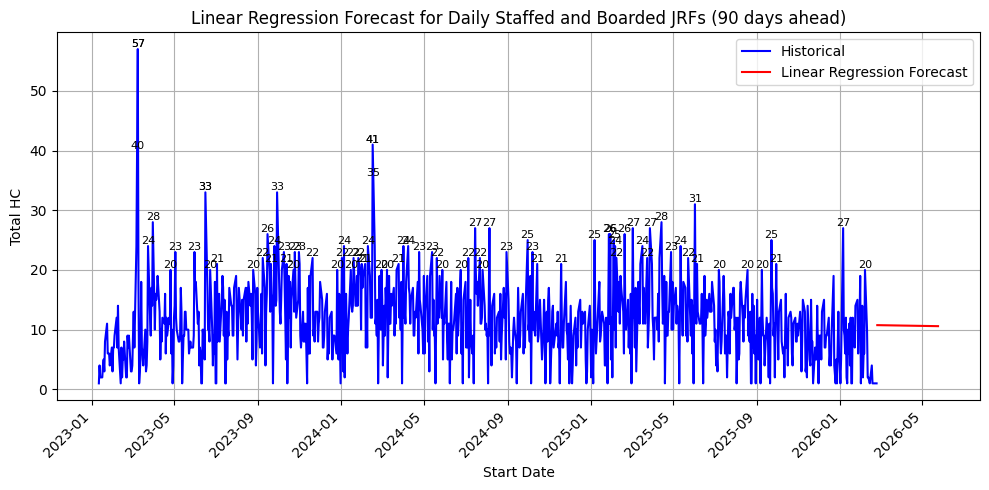

In [17]:
# --- Combine for plotting ---
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts.values, label='Historical', color='blue')
plt.plot(future_dates, forecast, color='red', label='Linear Regression Forecast')

# --- Add data labels for historical values ---
# for x, y in zip(ts.index, ts.values):
#     plt.text(
#         x,
#         y,
#         f"{y:.0f}",           # format label (no decimals)
#         fontsize=8,
#         color='black',
#         ha='center',
#         va='bottom'
#     )

# --- Add data labels for every 7 days  ---
# label_step = 7  # label every 7 days

# for i in range(0, len(ts), label_step):
#     plt.text(
#         ts.index[i],
#         ts.values[i],
#         f"{ts.values[i]:.0f}",
#         fontsize=8,
#         color='black',
#         ha='center',
#         va='bottom'
#     )

# Convert values to numpy array
y = ts.values

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only significant spikes (e.g., top 10% values)
threshold = np.percentile(y, 90)
significant_peaks = [p for p in peaks if y[p] >= threshold]

# Add data labels only for spikes
for i in significant_peaks:
    plt.text(
        ts.index[i],
        y[i],
        f"{y[i]:.0f}",
        fontsize=8,
        color='black',
        ha='center',
        va='bottom'
    )

# Number of spikes to label
top_n = 5

# Get indices of highest values
spike_indices = ts.nlargest(top_n).index

for date in spike_indices:
    value = ts.loc[date]
    plt.text(
        date,
        value,
        f"{value:.0f}",
        fontsize=8,
        color='black',
        ha='center',
        va='bottom'
    )

plt.title(f"Linear Regression Forecast for Daily Staffed and Boarded JRFs ({n_forecast} days ahead)")
plt.xlabel("Start Date")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Save forecast to CSV
# Combine actual + forecast into one DataFrame
# forecast_df = pd.DataFrame({
#     'date': future_dates,
#     'forecast_HC': forecast
# })

# Combine actual + forecast into one DataFrame
forecast_df = pd.DataFrame({
    "date": future_dates.strftime("%m/%d/%Y"),  # format date
    "forecast_HC": forecast
})

print(forecast_df.head(10))

# Save to CSV
forecast_df.to_csv('jrf_linear_regression_forecast_output.csv', index=False)
print("Forecast saved to 'jrf_linear_regression_forecast_output.csv'")

         date  forecast_HC
0  02/24/2026    10.752414
1  02/25/2026    10.750493
2  02/26/2026    10.748571
3  02/27/2026    10.746650
4  02/28/2026    10.744728
5  03/01/2026    10.742806
6  03/02/2026    10.740885
7  03/03/2026    10.738963
8  03/04/2026    10.737042
9  03/05/2026    10.735120
Forecast saved to 'jrf_linear_regression_forecast_output.csv'


In [19]:
# Week Time Series

# Group Week Start Date and Resource Required

week_time_series  = (
    data.group_by(["week_yyyy_start_date"])
        .agg([
            pl.sum("resource_required").alias("Total_HC")
        ])
    )


week_time_series = week_time_series.drop_nulls()

print(week_time_series.head(10))

shape: (10, 2)
┌──────────────────────┬──────────┐
│ week_yyyy_start_date ┆ Total_HC │
│ ---                  ┆ ---      │
│ str                  ┆ i64      │
╞══════════════════════╪══════════╡
│ 01-06-2025           ┆ 57       │
│ 09-08-2025           ┆ 56       │
│ 10-16-2023           ┆ 73       │
│ 01-20-2025           ┆ 43       │
│ 10-23-2023           ┆ 87       │
│ 11-04-2024           ┆ 52       │
│ 01-13-2025           ┆ 61       │
│ 08-12-2024           ┆ 53       │
│ 10-09-2023           ┆ 81       │
│ 02-20-2023           ┆ 29       │
└──────────────────────┴──────────┘


In [20]:
# Week Time Series

# --- Ensure 'week_start_date' is parsed as Datetime safely ---
if week_time_series.schema['week_yyyy_start_date'] == pl.Utf8:
    # Parse day-month-year format like "01-11-2023"
    week_time_series = week_time_series.with_columns(
        pl.col('week_yyyy_start_date')
        .str.strptime(pl.Datetime, "%m-%d-%Y", strict=False)
    )
else:
    # Already datetime-like — ensure consistent dtype
    week_time_series = week_time_series.with_columns(
        pl.col("week_yyyy_start_date").cast(pl.Datetime)
    )

# Sort by date
week_time_series = week_time_series.sort('week_yyyy_start_date')

print(week_time_series.head(10))

shape: (10, 2)
┌──────────────────────┬──────────┐
│ week_yyyy_start_date ┆ Total_HC │
│ ---                  ┆ ---      │
│ datetime[μs]         ┆ i64      │
╞══════════════════════╪══════════╡
│ 2023-01-09 00:00:00  ┆ 9        │
│ 2023-01-16 00:00:00  ┆ 24       │
│ 2023-01-23 00:00:00  ┆ 35       │
│ 2023-01-30 00:00:00  ┆ 35       │
│ 2023-02-06 00:00:00  ┆ 47       │
│ 2023-02-13 00:00:00  ┆ 29       │
│ 2023-02-20 00:00:00  ┆ 29       │
│ 2023-02-27 00:00:00  ┆ 40       │
│ 2023-03-06 00:00:00  ┆ 159      │
│ 2023-03-13 00:00:00  ┆ 42       │
└──────────────────────┴──────────┘


In [21]:
# --- Convert to Weekly frequency (manual resampling) ---

# Get min/max as Python datetime objects
week_min_date = week_time_series['week_yyyy_start_date'].min()
week_max_date = week_time_series['week_yyyy_start_date'].max()

# Convert to Python datetime if they’re Polars datetimes
if isinstance(week_min_date, pl.Series):
    week_min_date = week_min_date.to_list()[0]
if isinstance(week_max_date, pl.Series):
    week_max_date = week_max_date.to_list()[0]

# Display sample data
print(week_time_series.dtypes)
print(week_time_series.head(10))

[Datetime(time_unit='us', time_zone=None), Int64]
shape: (10, 2)
┌──────────────────────┬──────────┐
│ week_yyyy_start_date ┆ Total_HC │
│ ---                  ┆ ---      │
│ datetime[μs]         ┆ i64      │
╞══════════════════════╪══════════╡
│ 2023-01-09 00:00:00  ┆ 9        │
│ 2023-01-16 00:00:00  ┆ 24       │
│ 2023-01-23 00:00:00  ┆ 35       │
│ 2023-01-30 00:00:00  ┆ 35       │
│ 2023-02-06 00:00:00  ┆ 47       │
│ 2023-02-13 00:00:00  ┆ 29       │
│ 2023-02-20 00:00:00  ┆ 29       │
│ 2023-02-27 00:00:00  ┆ 40       │
│ 2023-03-06 00:00:00  ┆ 159      │
│ 2023-03-13 00:00:00  ┆ 42       │
└──────────────────────┴──────────┘


In [22]:
# --- Ensure 'week_start_date' is parsed as Datetime safely ---
if data.schema['week_yyyy_start_date'] == pl.Utf8:
    # Parse day-month-year format like "01-11-2023"
    data = data.with_columns(
        pl.col('week_yyyy_start_date')
        .str.strptime(pl.Datetime, "%m-%d-%Y", strict=False)
    )
else:
    # Already datetime-like — ensure consistent dtype
    data = data.with_columns(pl.col('week_yyyy_start_date').cast(pl.Datetime))

# --- Ensure 'week_start_date' in data is parsed as Datetime[μs] ---
if data.schema["week_yyyy_start_date"] == pl.Utf8:
    # Handle common formats like "01-11-2023" or "2023-01-11"
    data = data.with_columns(
        pl.when(pl.col("week_yyyy_start_date").str.contains("-"))
        .then(
            pl.col("week_yyyy_start_date").str.strptime(
                pl.Datetime("us"),
                format="%Y-%m-%d",
                strict=False
            )
        )
        .otherwise(
            pl.col("week_yyyy_start_date").str.strptime(
                pl.Datetime("us"),
                format="%m-%d-%Y %H:%M:%S",
                strict=False
            )
        )
        .alias("week_yyyy_start_date")
    )
else:
    # Already datetime — just ensure precision matches
    data = data.with_columns(pl.col("week_yyyy_start_date").cast(pl.Datetime("us")))

print(week_time_series.head(10))
print(data["product","resource_required","region","date_requested","start_date","week_yyyy_start_date","mm_yyyy_start_date"].head(10))

shape: (10, 2)
┌──────────────────────┬──────────┐
│ week_yyyy_start_date ┆ Total_HC │
│ ---                  ┆ ---      │
│ datetime[μs]         ┆ i64      │
╞══════════════════════╪══════════╡
│ 2023-01-09 00:00:00  ┆ 9        │
│ 2023-01-16 00:00:00  ┆ 24       │
│ 2023-01-23 00:00:00  ┆ 35       │
│ 2023-01-30 00:00:00  ┆ 35       │
│ 2023-02-06 00:00:00  ┆ 47       │
│ 2023-02-13 00:00:00  ┆ 29       │
│ 2023-02-20 00:00:00  ┆ 29       │
│ 2023-02-27 00:00:00  ┆ 40       │
│ 2023-03-06 00:00:00  ┆ 159      │
│ 2023-03-13 00:00:00  ┆ 42       │
└──────────────────────┴──────────┘
shape: (10, 7)
┌────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬────────────────┐
│ product        ┆ resource_requi ┆ region         ┆ date_requested ┆ start_date     ┆ week_yyyy_star ┆ mm_yyyy_start_ │
│ ---            ┆ red            ┆ ---            ┆ ---            ┆ ---            ┆ t_date         ┆ date           │
│ str            ┆ ---         

In [23]:
# --- Generate week date range as Datetime ---
# 'time_unit' is no longer accepted; cast manually after creation
week_range = (
    pl.date_range(
        start=week_min_date,
        end=week_max_date,
        interval="1w",
        eager=True
    )
    .cast(pl.Datetime("us"))  # ensure same precision as start_date
)

# Convert to DataFrame
week_range_df = pl.DataFrame({"week_yyyy_start_date": week_range})

# --- Join with original data to ensure week continuity ---
# week data
week_range_df  = (
    week_range_df
    .join(data, on="week_yyyy_start_date", how="left")
    .fill_null(strategy="forward")  # optional: fill missing days
)

print(week_time_series.head(10))
print(week_range.head(10))
print(week_range_df.head(10))

shape: (10, 2)
┌──────────────────────┬──────────┐
│ week_yyyy_start_date ┆ Total_HC │
│ ---                  ┆ ---      │
│ datetime[μs]         ┆ i64      │
╞══════════════════════╪══════════╡
│ 2023-01-09 00:00:00  ┆ 9        │
│ 2023-01-16 00:00:00  ┆ 24       │
│ 2023-01-23 00:00:00  ┆ 35       │
│ 2023-01-30 00:00:00  ┆ 35       │
│ 2023-02-06 00:00:00  ┆ 47       │
│ 2023-02-13 00:00:00  ┆ 29       │
│ 2023-02-20 00:00:00  ┆ 29       │
│ 2023-02-27 00:00:00  ┆ 40       │
│ 2023-03-06 00:00:00  ┆ 159      │
│ 2023-03-13 00:00:00  ┆ 42       │
└──────────────────────┴──────────┘
shape: (10,)
Series: 'literal' [datetime[μs]]
[
	2023-01-09 00:00:00
	2023-01-16 00:00:00
	2023-01-23 00:00:00
	2023-01-30 00:00:00
	2023-02-06 00:00:00
	2023-02-13 00:00:00
	2023-02-20 00:00:00
	2023-02-27 00:00:00
	2023-03-06 00:00:00
	2023-03-13 00:00:00
]
shape: (10, 22)
┌───────────────────┬──────────────┬──────┬─────────────────┬───┬────────┬───────┬──────────────────┬──────────────────┐
│ week_yyyy_

In [24]:
# Save Week Time Series to CSV
week_time_series = (
    pl.DataFrame({
        "Week Start Date": week_time_series["week_yyyy_start_date"],
        "Actual HC": week_time_series["Total_HC"]
    })
    .with_columns(
        pl.col("Week Start Date")
        .dt.strftime("%m/%d/%Y")   # format as MM/DD/YYYY
    )
)

print(week_time_series.head(10))

# Save to CSV
week_time_series.write_csv('jrf_week_time_series_output.csv')
print("Week Time Series saved to 'jrf_week_time_series_output.csv'")

shape: (10, 2)
┌─────────────────┬───────────┐
│ Week Start Date ┆ Actual HC │
│ ---             ┆ ---       │
│ str             ┆ i64       │
╞═════════════════╪═══════════╡
│ 01/09/2023      ┆ 9         │
│ 01/16/2023      ┆ 24        │
│ 01/23/2023      ┆ 35        │
│ 01/30/2023      ┆ 35        │
│ 02/06/2023      ┆ 47        │
│ 02/13/2023      ┆ 29        │
│ 02/20/2023      ┆ 29        │
│ 02/27/2023      ┆ 40        │
│ 03/06/2023      ┆ 159       │
│ 03/13/2023      ┆ 42        │
└─────────────────┴───────────┘
Week Time Series saved to 'jrf_week_time_series_output.csv'


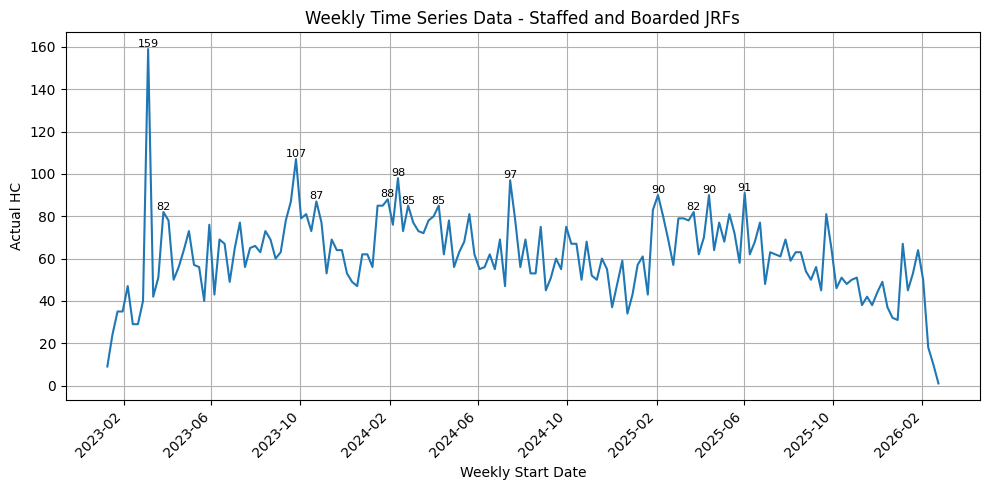

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks

plt.figure(figsize=(10, 5))

# --- Plot weekly time series ---
# x = week_time_series["week_yyyy_start_date"].to_list()
# y = week_time_series["Total_HC"].to_list()

# x = week_time_series["Week Start Date"].to_list()
# y = week_time_series["Actual HC"].to_list()

plot_df = week_time_series.to_pandas()
plot_df["Week Start Date"] = pd.to_datetime(plot_df["Week Start Date"])

x = plot_df["Week Start Date"]
y = plot_df["Actual HC"].values

plt.plot(x, y, label="Historical")

# --- Detect spikes ---
y_np = np.array(y)

# Find local peaks
peaks, _ = find_peaks(y_np)

# Keep only major spikes (top 10%)
threshold = np.percentile(y_np, 90)
major_peaks = [p for p in peaks if y_np[p] >= threshold]

# --- Add data labels for spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y_np[i],
        f"{int(y_np[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Format x-axis to YYYY-MM ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))


# Visualize the time series
# --- Formatting ---
# plt.figure(figsize=(10, 5))
# plt.plot(week_time_series['week_yyyy_start_date'], week_time_series['Total_HC'])
plt.title("Weekly Time Series Data - Staffed and Boarded JRFs")
plt.xlabel("Weekly Start Date")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Actual HC")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Fit the ARIMA model
# --- Convert to Pandas DataFrame ---
week_df = week_time_series.to_pandas()

# --- Check column names and clean ---
week_df.columns = week_df.columns.str.strip()  # remove trailing spaces
print("Available columns:", week_df.columns.tolist())

# --- Ensure 'Total_HC' column exists and has numeric values ---
if "Actual HC" not in week_df.columns:
    raise KeyError("Column 'Actual HC' not found in DataFrame after conversion.")

week_df["Actual HC"] = pd.to_numeric(week_df["Actual HC"], errors="coerce")


# Convert to time series (weekly frequency)
week_ts = (
    week_time_series.to_pandas()
    .set_index('Week Start Date')['Actual HC']
    .sort_index()   
)

print(week_time_series.head(10))
# print(plot_df["Week Start Date"].head(10))
print(plot_df.head(10))
print(week_df.head(10))
print(week_ts.head(10))

Available columns: ['Week Start Date', 'Actual HC']
shape: (10, 2)
┌─────────────────┬───────────┐
│ Week Start Date ┆ Actual HC │
│ ---             ┆ ---       │
│ str             ┆ i64       │
╞═════════════════╪═══════════╡
│ 01/09/2023      ┆ 9         │
│ 01/16/2023      ┆ 24        │
│ 01/23/2023      ┆ 35        │
│ 01/30/2023      ┆ 35        │
│ 02/06/2023      ┆ 47        │
│ 02/13/2023      ┆ 29        │
│ 02/20/2023      ┆ 29        │
│ 02/27/2023      ┆ 40        │
│ 03/06/2023      ┆ 159       │
│ 03/13/2023      ┆ 42        │
└─────────────────┴───────────┘
  Week Start Date  Actual HC
0      2023-01-09          9
1      2023-01-16         24
2      2023-01-23         35
3      2023-01-30         35
4      2023-02-06         47
5      2023-02-13         29
6      2023-02-20         29
7      2023-02-27         40
8      2023-03-06        159
9      2023-03-13         42
  Week Start Date  Actual HC
0      01/09/2023          9
1      01/16/2023         24
2      01/23/20

In [27]:
# --- Ensure time series has explicit weekly frequency ---
# if week_ts.index.freq is None:
#     week_ts = week_ts.asfreq("W-MON")  # set start of week as Monday (you can also use 'W-SUN')

# --- Create weekly time series ---
# week_ts = (
#     week_df
#     .set_index("Week Start Date")["Actual HC"]
#     .sort_index()
# )

# --- Create weekly time series ---
week_ts = (
    plot_df
    .set_index("Week Start Date")["Actual HC"]
    .sort_index()
    .asfreq("W-MON")          # IMPORTANT: weekly frequency
    .interpolate()
)
    
# Fit ARIMA model (p, d, q)
model = ARIMA(week_ts, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())
print(week_df.head(10))
print(week_ts.head(10))

                               SARIMAX Results                                
Dep. Variable:              Actual HC   No. Observations:                  164
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -689.278
Date:                Fri, 06 Feb 2026   AIC                           1384.556
Time:                        02:36:41   BIC                           1393.837
Sample:                    01-09-2023   HQIC                          1388.324
                         - 02-23-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0003      0.128     -0.002      0.998      -0.252       0.251
ma.L1         -0.7086      0.109     -6.474      0.000      -0.923      -0.494
sigma2       274.5756      9.790     28.048      0.0

In [28]:
# --- Forecast next N days ---
n_forecast = 90  # you can change this number as needed
forecast_result = model_fit.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

print(forecast)
print(week_ts)
print(forecast.index)


2026-03-02    23.417672
2026-03-09    23.410998
2026-03-16    23.411000
2026-03-23    23.411000
2026-03-30    23.411000
                ...    
2027-10-18    23.411000
2027-10-25    23.411000
2027-11-01    23.411000
2027-11-08    23.411000
2027-11-15    23.411000
Freq: W-MON, Name: predicted_mean, Length: 90, dtype: float64
Week Start Date
2023-01-09     9
2023-01-16    24
2023-01-23    35
2023-01-30    35
2023-02-06    47
              ..
2026-01-26    64
2026-02-02    50
2026-02-09    18
2026-02-16    10
2026-02-23     1
Freq: W-MON, Name: Actual HC, Length: 164, dtype: int64
DatetimeIndex(['2026-03-02', '2026-03-09', '2026-03-16', '2026-03-23',
               '2026-03-30', '2026-04-06', '2026-04-13', '2026-04-20',
               '2026-04-27', '2026-05-04', '2026-05-11', '2026-05-18',
               '2026-05-25', '2026-06-01', '2026-06-08', '2026-06-15',
               '2026-06-22', '2026-06-29', '2026-07-06', '2026-07-13',
               '2026-07-20', '2026-07-27', '2026-08-03', '20

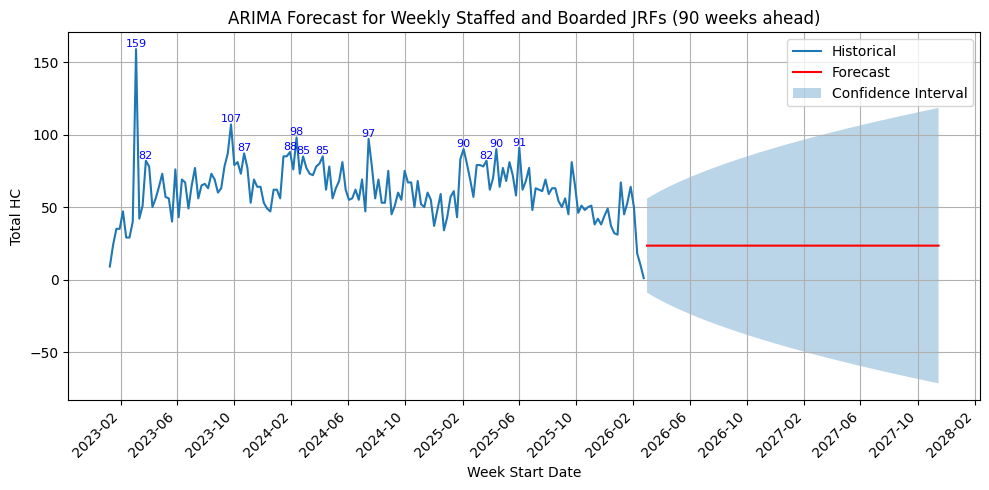

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks

plt.figure(figsize=(10, 5))

# --- Plot historical + forecast ---
plt.plot(week_ts.index, week_ts.values, label="Historical")
plt.plot(forecast.index, forecast, color="red", label="Forecast")

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.3,
    label="Confidence Interval"
)

# --- Detect largest spikes in historical data ---
# y = week_ts.values
# x = week_ts.index
# x = week_df["Week Start Date"]

plot_df = week_time_series.to_pandas()
plot_df["Week Start Date"] = pd.to_datetime(plot_df["Week Start Date"])

x = plot_df["Week Start Date"]
y = week_ts.values

# plot_df = week_time_series.to_pandas()
# plot_df["Week Start Date"] = pd.to_datetime(plot_df["Week Start Date"])

# x = plot_df["Week Start Date"]
# y = plot_df["Actual HC"].values

# Find peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="blue",
        ha="center",
        va="bottom"
    )

# --- Format x-axis to YYYY-MM ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))

# --- Without Data Label ---
# --- Plot actual + forecast ---
# plt.figure(figsize=(10, 5))
# plt.plot(week_ts, label='Historical')
# plt.plot(forecast.index, forecast, color='red', label='Forecast')
# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],
#     conf_int.iloc[:, 1],
#     color='pink',
#     alpha=0.3,
#     label='Confidence Interval'
# )

plt.title(f"ARIMA Forecast for Weekly Staffed and Boarded JRFs ({n_forecast} weeks ahead)")
plt.xlabel("Week Start Date")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
import polars as pl

# Save Weekly forecast to CSV
# Convert Weekly forecast to Polars for saving
# weekly_forecast_df = pl.DataFrame({
#     'Weeky Start Date': forecast.index,
#     'Forecast HC': forecast.values
# })

weekly_forecast_df = (
    pl.DataFrame({
    'Weeky Start Date': forecast.index,
    'Forecast HC': forecast.values
    })
    .with_columns(
        pl.col("Weeky Start Date")
        .dt.strftime("%m/%d/%Y")   # format as MM/DD/YYYY
    )
)

print(weekly_forecast_df)
print(forecast.index)
print(forecast.values)

weekly_forecast_df.write_csv('jrf_weekly_arima_forecast_output.csv')

print("Forecast saved to 'jrf_weekly_arima_forecast_output.csv'")

shape: (90, 2)
┌──────────────────┬─────────────┐
│ Weeky Start Date ┆ Forecast HC │
│ ---              ┆ ---         │
│ str              ┆ f64         │
╞══════════════════╪═════════════╡
│ 03/02/2026       ┆ 23.417672   │
│ 03/09/2026       ┆ 23.410998   │
│ 03/16/2026       ┆ 23.411      │
│ 03/23/2026       ┆ 23.411      │
│ 03/30/2026       ┆ 23.411      │
│ …                ┆ …           │
│ 10/18/2027       ┆ 23.411      │
│ 10/25/2027       ┆ 23.411      │
│ 11/01/2027       ┆ 23.411      │
│ 11/08/2027       ┆ 23.411      │
│ 11/15/2027       ┆ 23.411      │
└──────────────────┴─────────────┘
DatetimeIndex(['2026-03-02', '2026-03-09', '2026-03-16', '2026-03-23',
               '2026-03-30', '2026-04-06', '2026-04-13', '2026-04-20',
               '2026-04-27', '2026-05-04', '2026-05-11', '2026-05-18',
               '2026-05-25', '2026-06-01', '2026-06-08', '2026-06-15',
               '2026-06-22', '2026-06-29', '2026-07-06', '2026-07-13',
               '2026-07-20', '2026-

In [31]:
# Convert datetime index to ordinal numbers (numeric days)
X = np.arange(len(week_ts)).reshape(-1, 1)
y = week_ts.values

# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Model summary
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Summary")
print("-----------------------------------")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("-----------------------------------\n")


Linear Regression Model Summary
-----------------------------------
Coefficient (slope): -0.0715
Intercept: 67.3729
R² Score: 0.0317
RMSE: 18.7239
-----------------------------------



In [32]:
# --- Forecast next N days ---
n_forecast = 90
future_X = np.arange(len(week_ts), len(week_ts) + n_forecast).reshape(-1, 1)
forecast = model.predict(future_X)

# Create datetime index for forecast horizon
last_date = week_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='W')

In [33]:
# --- Ensure Week Start Date is always Monday ---
# Convert to pandas datetime and shift to Monday
week_start_dates = (
    pd.to_datetime(future_dates)
    .map(lambda d: d - pd.Timedelta(days=d.weekday()))
)

# --- Convert forecast dates to YYYY-MM-DD strings ---
# forecast_dates_str = [
#     d.strftime("%Y-%m-%d") for d in future_dates.to_pydatetime()
# ]
forecast_dates_str = [
    d.strftime("%m/%d/%Y") for d in future_dates.to_pydatetime()
]

# --- Convert to YYYY-MM-DD strings ---
# forecast_dates_str = week_start_dates.strftime("%Y-%m-%d").tolist()
forecast_dates_str = week_start_dates.strftime("%m/%d/%Y").tolist()

# --- Create Polars DataFrame ---
forecast_df = pl.DataFrame({
    "Week Start Date": forecast_dates_str,   # keep as string to preserve format
    "Linear Regression Forecast HC": forecast.round(0).astype(int)
})

# --- Save to CSV ---
forecast_df.write_csv("jrf_weekly_linear_regression_forecast.csv")

print(forecast_df.head(10))

print("Weekly forecast saved to 'jrf_weekly_linear_regression_forecast.csv'")

shape: (10, 2)
┌─────────────────┬───────────────────────────────┐
│ Week Start Date ┆ Linear Regression Forecast HC │
│ ---             ┆ ---                           │
│ str             ┆ i64                           │
╞═════════════════╪═══════════════════════════════╡
│ 02/23/2026      ┆ 56                            │
│ 03/02/2026      ┆ 56                            │
│ 03/09/2026      ┆ 55                            │
│ 03/16/2026      ┆ 55                            │
│ 03/23/2026      ┆ 55                            │
│ 03/30/2026      ┆ 55                            │
│ 04/06/2026      ┆ 55                            │
│ 04/13/2026      ┆ 55                            │
│ 04/20/2026      ┆ 55                            │
│ 04/27/2026      ┆ 55                            │
└─────────────────┴───────────────────────────────┘
Weekly forecast saved to 'jrf_weekly_linear_regression_forecast.csv'


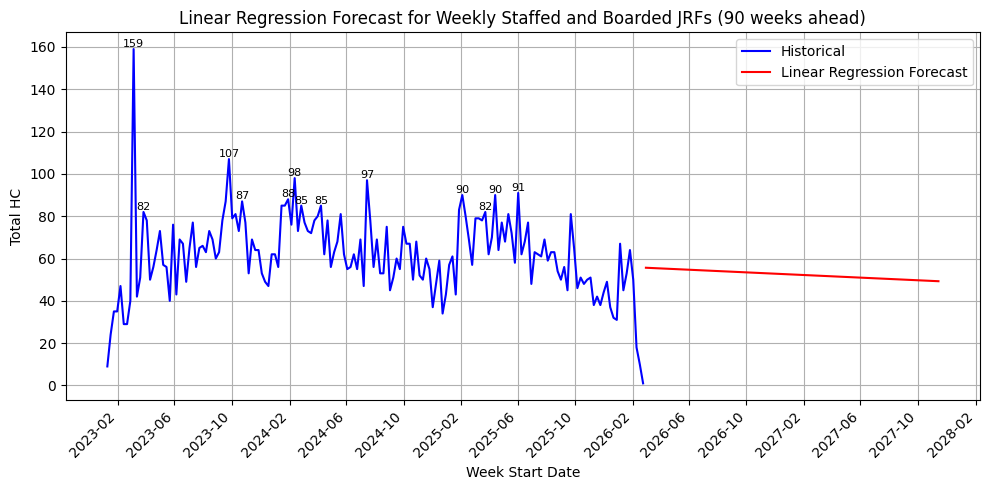

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks

plt.figure(figsize=(10, 5))

# --- Plot historical + forecast ---
plt.plot(week_ts.index, week_ts.values, label="Historical", color="blue")
plt.plot(future_dates, forecast, color="red", label="Linear Regression Forecast")

# --- Detect largest spikes in historical data ---
y = week_ts.values
x = week_ts.index

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for major spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Format x-axis to YYYY-MM ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))

# --- Combine for plotting ---
# plt.figure(figsize=(10, 5))
# plt.plot(week_ts.index, week_ts.values, label='Historical', color='blue')
# plt.plot(future_dates, forecast, color='red', label='Linear Regression Forecast')

plt.title(f"Linear Regression Forecast for Weekly Staffed and Boarded JRFs ({n_forecast} weeks ahead)")
plt.xlabel("Week Start Date")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Monthly Time Series
# Group Monthly Start Date and Resource Required

# month_time_series  = (
#     data.group_by(["mm_yyyy_start_date"])
#         .agg([
#             pl.sum("resource_required").alias("Total_HC")
#         ])
# )

# month_time_series = month_time_series.drop_nulls()

# # Sort by Month
# month_time_series = month_time_series.sort('mm_yyyy_start_date')

month_time_series = (
    data
    .group_by("mm_yyyy_start_date")
    .agg(
        pl.sum("resource_required").alias("Total_HC")
    )
    .drop_nulls()
    .with_columns(
        pl.col("mm_yyyy_start_date")
        .str.strptime(pl.Date, "%Y-%m", strict=False)  # adjust format if needed
        .dt.strftime("%Y-%m")
        .alias("mm_yyyy_start_date")
    )
    .sort("mm_yyyy_start_date")
)

# Save to CSV
month_time_series.write_csv('jrf_monthly_time_series_output.csv')
print("Monthly Time Series saved to 'jrf_monthly_time_series_output.csv'")

print(month_time_series.head(10))

Monthly Time Series saved to 'jrf_monthly_time_series_output.csv'
shape: (10, 2)
┌────────────────────┬──────────┐
│ mm_yyyy_start_date ┆ Total_HC │
│ ---                ┆ ---      │
│ str                ┆ i64      │
╞════════════════════╪══════════╡
│ 2023-01            ┆ 78       │
│ 2023-02            ┆ 136      │
│ 2023-03            ┆ 368      │
│ 2023-04            ┆ 248      │
│ 2023-05            ┆ 265      │
│ 2023-06            ┆ 263      │
│ 2023-07            ┆ 284      │
│ 2023-08            ┆ 297      │
│ 2023-09            ┆ 350      │
│ 2023-10            ┆ 358      │
└────────────────────┴──────────┘


In [36]:
# Monthly Time Series

# --- Ensure 'month_start_date' is parsed as Datetime safely ---
if month_time_series.schema['mm_yyyy_start_date'] == pl.Utf8:
    month_time_series = month_time_series.with_columns(
        pl.col('mm_yyyy_start_date')
        .str.strptime(pl.Datetime, "%Y-%m", strict=False)
    )
else:
    # Already datetime-like — ensure consistent dtype
    month_time_series = month_time_series.with_columns(
        pl.col("mm_yyyy_start_date").cast(pl.Datetime)
    )

# Sort by date
month_time_series = month_time_series.sort('mm_yyyy_start_date')

print(month_time_series.head(10))

shape: (10, 2)
┌─────────────────────┬──────────┐
│ mm_yyyy_start_date  ┆ Total_HC │
│ ---                 ┆ ---      │
│ datetime[μs]        ┆ i64      │
╞═════════════════════╪══════════╡
│ 2023-01-01 00:00:00 ┆ 78       │
│ 2023-02-01 00:00:00 ┆ 136      │
│ 2023-03-01 00:00:00 ┆ 368      │
│ 2023-04-01 00:00:00 ┆ 248      │
│ 2023-05-01 00:00:00 ┆ 265      │
│ 2023-06-01 00:00:00 ┆ 263      │
│ 2023-07-01 00:00:00 ┆ 284      │
│ 2023-08-01 00:00:00 ┆ 297      │
│ 2023-09-01 00:00:00 ┆ 350      │
│ 2023-10-01 00:00:00 ┆ 358      │
└─────────────────────┴──────────┘


In [37]:
# Get min/max as Python datetime objects
month_min = month_time_series['mm_yyyy_start_date'].min()
month_max = month_time_series['mm_yyyy_start_date'].max()

print(month_min)
print(month_max)

2023-01-01 00:00:00
2026-02-01 00:00:00


In [38]:
month_range = (
    pl.date_range(
        start=month_min,
        end=month_max,
        interval="1mo", # use 1mo for monthly interval
        eager=True
    )
    .cast(pl.Datetime("us"))  # ensure same precision as start_date
)

print(month_range.head(10))


shape: (10,)
Series: 'literal' [datetime[μs]]
[
	2023-01-01 00:00:00
	2023-02-01 00:00:00
	2023-03-01 00:00:00
	2023-04-01 00:00:00
	2023-05-01 00:00:00
	2023-06-01 00:00:00
	2023-07-01 00:00:00
	2023-08-01 00:00:00
	2023-09-01 00:00:00
	2023-10-01 00:00:00
]


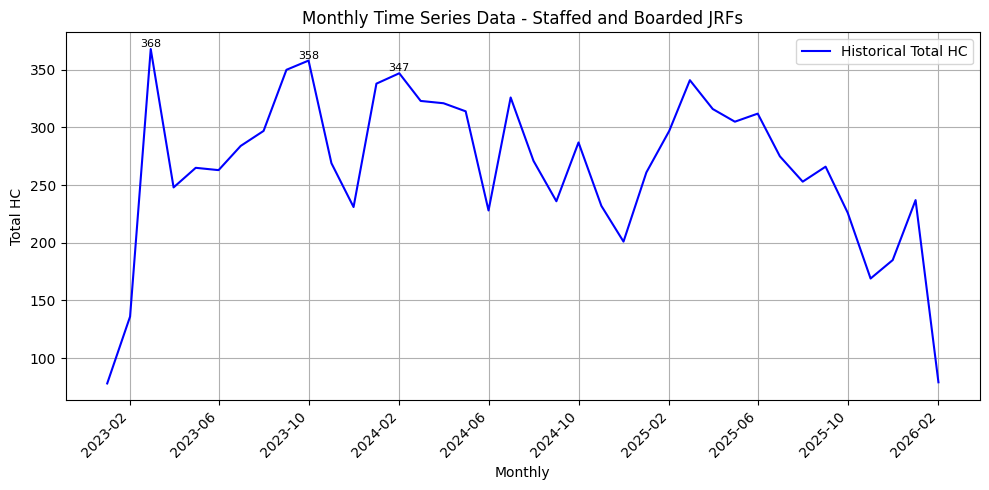

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks

# Visualize the time series
plt.figure(figsize=(10, 5))

# --- Detect largest spikes in historical data ---
x = month_time_series['mm_yyyy_start_date'].to_pandas()
y = month_time_series['Total_HC'].to_numpy()

# --- Plot historical ---
plt.plot(x, y, label="Historical Total HC", color="blue")

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for major spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Format x-axis to YYYY-MM ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.title("Monthly Time Series Data - Staffed and Boarded JRFs")
plt.xlabel("Monthly")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(10, 5))
# plt.plot(month_time_series['mm_yyyy_start_date'], month_time_series['Total_HC'])
# plt.title("Monthly Time Series Data - Staffed and Boarded JRFs")
# plt.xlabel("Monthly")
# plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
# plt.tight_layout()  # Adjust layout so labels fit nicely
# plt.ylabel("Total HC")
# plt.grid(True)
# plt.show()

In [40]:
# Fit the ARIMA model
# --- Convert to Pandas DataFrame ---
month_df = month_time_series.to_pandas()

# --- Check column names and clean ---
month_df.columns = month_df.columns.str.strip()  # remove trailing spaces
print("Available columns:", month_df.columns.tolist())

# --- Ensure 'Total_HC' column exists and has numeric values ---
if "Total_HC" not in month_df.columns:
    raise KeyError("Column 'Total_HC' not found in DataFrame after conversion.")

month_df["Total_HC"] = pd.to_numeric(month_df["Total_HC"], errors="coerce")


# Convert to time series (Monthly frequency)
month_ts = (
    month_time_series.to_pandas()
    .set_index('mm_yyyy_start_date')['Total_HC']
    .sort_index()   
)

print(month_time_series.head(10))
print(month_df.head(10))
print(month_ts.head(10))

Available columns: ['mm_yyyy_start_date', 'Total_HC']
shape: (10, 2)
┌─────────────────────┬──────────┐
│ mm_yyyy_start_date  ┆ Total_HC │
│ ---                 ┆ ---      │
│ datetime[μs]        ┆ i64      │
╞═════════════════════╪══════════╡
│ 2023-01-01 00:00:00 ┆ 78       │
│ 2023-02-01 00:00:00 ┆ 136      │
│ 2023-03-01 00:00:00 ┆ 368      │
│ 2023-04-01 00:00:00 ┆ 248      │
│ 2023-05-01 00:00:00 ┆ 265      │
│ 2023-06-01 00:00:00 ┆ 263      │
│ 2023-07-01 00:00:00 ┆ 284      │
│ 2023-08-01 00:00:00 ┆ 297      │
│ 2023-09-01 00:00:00 ┆ 350      │
│ 2023-10-01 00:00:00 ┆ 358      │
└─────────────────────┴──────────┘
  mm_yyyy_start_date  Total_HC
0         2023-01-01        78
1         2023-02-01       136
2         2023-03-01       368
3         2023-04-01       248
4         2023-05-01       265
5         2023-06-01       263
6         2023-07-01       284
7         2023-08-01       297
8         2023-09-01       350
9         2023-10-01       358
mm_yyyy_start_date
2023-01-01 

In [41]:
# --- Ensure time series has explicit monthly frequency ---
# returns the month end date
# month_ts = (
#     week_ts
#     .resample("M")        # 'M' = Month End
#     .sum()                # or use .mean() depending on what "Total_HC" represents
#     .interpolate()        # fill any missing values
# )

# Use resample('MS') to enforce monthly frequency safely
month_ts = (
    month_ts.resample("MS").sum()  # or .mean() if appropriate
    .interpolate()                 # fill any missing months smoothly
)
   
# Fit ARIMA model (p, d, q)
model = ARIMA(month_ts, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())
print(month_ts.head(10))

                               SARIMAX Results                                
Dep. Variable:               Total_HC   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -206.103
Date:                Fri, 06 Feb 2026   AIC                            418.205
Time:                        02:37:13   BIC                            423.038
Sample:                    01-01-2023   HQIC                           419.909
                         - 02-01-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1916      0.411      0.466      0.641      -0.613       0.997
ma.L1         -0.5937      0.382     -1.553      0.120      -1.343       0.155
sigma2      4008.7624    588.190      6.815      0.0

In [42]:
# --- Forecast next N days ---
n_forecast = 30  # you can change this number as needed
forecast_result = model_fit.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


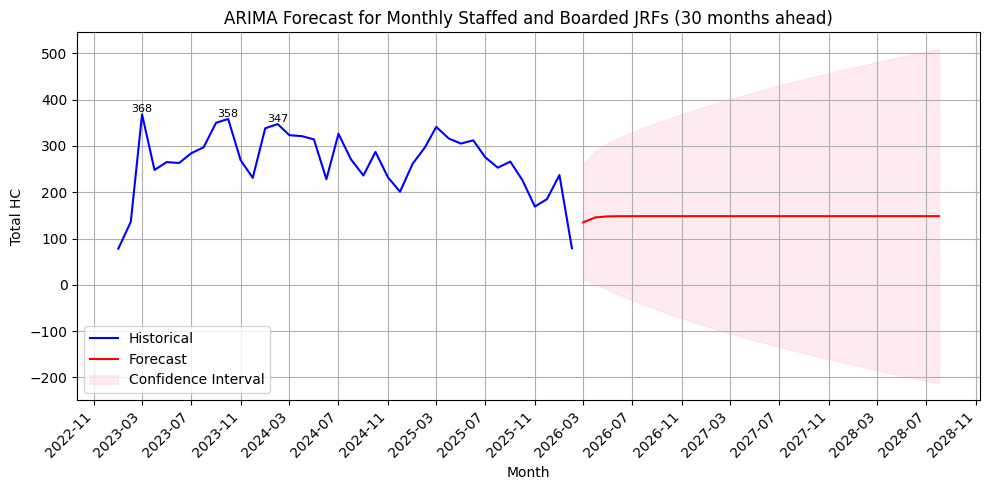

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks

# --- Plot actual + forecast ---
plt.figure(figsize=(10, 5))

# --- Plot historical ---
plt.plot(month_ts, label='Historical', color="blue")
plt.plot(forecast.index, forecast, color='red', label='Forecast')
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# --- Detect largest spikes in historical data ---
x = month_ts.index
y = month_ts.values

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for major spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Format x-axis to YYYY-MM ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.title(f"ARIMA Forecast for Monthly Staffed and Boarded JRFs ({n_forecast} months ahead)")
plt.xlabel("Month")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# Save Monthly forecast to CSV

# --- Convert forecast index to YYYY-MM strings ---
forecast_months = [
    d.strftime("%Y-%m") for d in forecast.index.to_pydatetime()
]

# --- Create Polars DataFrame ---
# Convert Monthly forecast to Polars for saving
monthly_forecast_df = pl.DataFrame({
    "Month": forecast_months,                 # formatted YYYY-MM
    "ARIMA Forecast HC": forecast.round(0).astype(int)
})

monthly_forecast_df.write_csv('jrf_monthly_arima_forecast_output.csv')

print("Forecast saved to 'jrf_monthly_arima_forecast_output.csv'")

Forecast saved to 'jrf_monthly_arima_forecast_output.csv'


In [45]:
# Convert datetime index to ordinal numbers (numeric months)
X = np.arange(len(month_ts)).reshape(-1, 1)
y = month_ts.values

# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Model summary
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Summary")
print("-----------------------------------")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("-----------------------------------\n")


Linear Regression Model Summary
-----------------------------------
Coefficient (slope): -1.0908
Intercept: 285.7854
R² Score: 0.0303
RMSE: 67.6815
-----------------------------------



In [46]:
# --- Forecast next N months ---
n_forecast = 30
future_X = np.arange(len(month_ts), len(month_ts) + n_forecast).reshape(-1, 1)
forecast = model.predict(future_X)

# Create datetime index for forecast horizon
last_date = month_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='MS')

In [47]:
# --- Create Polars DataFrame ---
monthly_forecast_df = pl.DataFrame({
    'Month': [d.strftime("%Y-%m") for d in future_dates],
    'Linear Regression Forecast HC': forecast.round(0).astype(int)
})

# --- Save to CSV ---
monthly_forecast_df.write_csv("jrf_monthly_linear_regression_forecast.csv")

print("Monthly forecast saved to 'jrf_monthly_linear_regression_forecast.csv'")

Monthly forecast saved to 'jrf_monthly_linear_regression_forecast.csv'


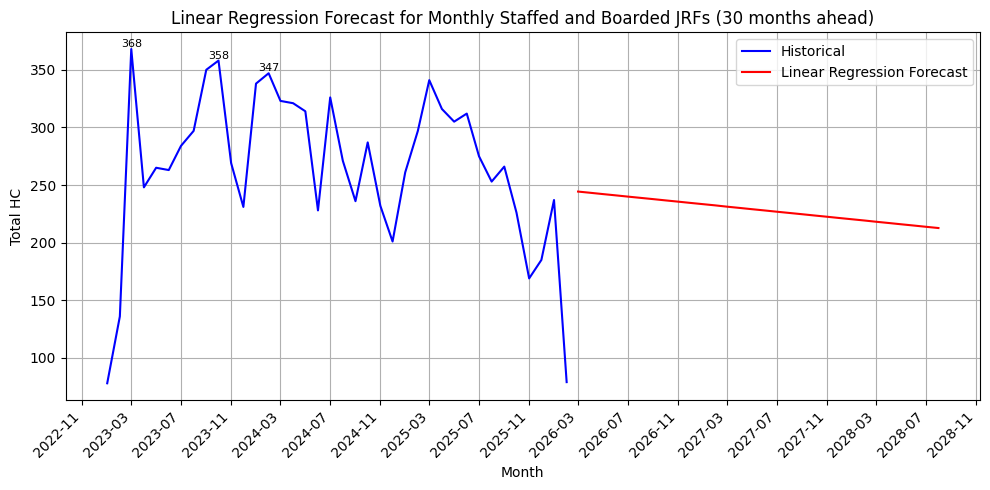

In [48]:
# --- Combine for plotting ---
plt.figure(figsize=(10, 5))
plt.plot(month_ts.index, month_ts.values, label='Historical', color='blue')
plt.plot(future_dates, forecast, color='red', label='Linear Regression Forecast')

# --- Detect largest spikes in historical data ---
x = month_ts.index
y = month_ts.values

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for major spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Format the x-axis as YYYY-MM ---
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # show every month (adjust interval as needed)

# --- Rotate and align x labels ---
plt.xticks(rotation=45, ha='right')

plt.title(f"Linear Regression Forecast for Monthly Staffed and Boarded JRFs ({n_forecast} months ahead)")
plt.xlabel("Month")
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Group Product, Start Date, Resource Required

product_summary = (
    data.group_by(["product", "start_date","week_yyyy_start_date","mm_yyyy_start_date"])
        .agg([
            pl.sum("resource_required").alias("Total_HC")
        ])
        .drop_nulls()
        .sort(by=["start_date", "product"],
            descending=[True, False])  # <-- sorting here
     
)

product_summary = product_summary.with_columns(
    pl.col("start_date").cast(pl.Date),
    pl.col("week_yyyy_start_date").cast(pl.Date)
)

print(product_summary.head(10))

shape: (10, 5)
┌───────────────────────────────┬────────────┬──────────────────────┬────────────────────┬──────────┐
│ product                       ┆ start_date ┆ week_yyyy_start_date ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---                           ┆ ---        ┆ ---                  ┆ ---                ┆ ---      │
│ str                           ┆ date       ┆ date                 ┆ str                ┆ i64      │
╞═══════════════════════════════╪════════════╪══════════════════════╪════════════════════╪══════════╡
│ Healthcare VA Part Time Mid   ┆ 2026-02-23 ┆ 2026-02-23           ┆ 2026-02            ┆ 1        │
│ Ecommerce Assistant FT        ┆ 2026-02-22 ┆ 2026-02-16           ┆ 2026-02            ┆ 1        │
│ Ecommerce Assistant FT        ┆ 2026-02-21 ┆ 2026-02-16           ┆ 2026-02            ┆ 1        │
│ Ecommerce Assistant FT        ┆ 2026-02-20 ┆ 2026-02-16           ┆ 2026-02            ┆ 1        │
│ Ecommerce Assistant FT        ┆ 2026-02-19 ┆ 2026-02-16          

In [50]:
# Select and rename columns for export
product_ts_df = product_summary.select([
    pl.col("product").alias("Product"),
    pl.col("start_date").alias("Start Date"),
    pl.col("Total_HC").alias("Actual HC")
])

# Save to CSV
product_ts_df.write_csv("jrf_product_time_series_output.csv")

print("Time Series saved to 'jrf_product_time_series_output.csv'")

Time Series saved to 'jrf_product_time_series_output.csv'


In [51]:
# Fit the ARIMA model
# Convert to pandas Series with datetime index (required by statsmodels)
product_ps = (
    product_ts_df.to_pandas()
    .set_index('Start Date')['Actual HC']
    .asfreq('D')  # explicitly set daily frequency / W for weekly / M for monthly
)

# Ensure index is sorted and no missing timestamps
product_ps = product_ps.sort_index().interpolate()

print(product_ps.head(10))

ValueError: cannot reindex on an axis with duplicate labels

shape: (10, 3)
┌─────────────────────────────────┬────────────┬───────────┐
│ Product                         ┆ Start Date ┆ Actual HC │
│ ---                             ┆ ---        ┆ ---       │
│ str                             ┆ date       ┆ i64       │
╞═════════════════════════════════╪════════════╪═══════════╡
│ CSR Full Time                   ┆ 2026-01-30 ┆ 2         │
│ Executive Assistant Part Time   ┆ 2026-01-30 ┆ 1         │
│ Social Media Part Time Expert   ┆ 2026-01-30 ┆ 1         │
│ Digital Marketing Assistant PT… ┆ 2026-01-29 ┆ 1         │
│ Dedicated SDR Full Time         ┆ 2026-01-28 ┆ 1         │
│ Digital Marketing Assistant PT… ┆ 2026-01-28 ┆ 1         │
│ Executive Assistant Part Time … ┆ 2026-01-28 ┆ 1         │
│ Real Estate Full Time Expert    ┆ 2026-01-28 ┆ 1         │
│ Digital Marketing Assistant PT… ┆ 2026-01-27 ┆ 1         │
│ Executive Assistant Full Time … ┆ 2026-01-26 ┆ 1         │
└─────────────────────────────────┴────────────┴───────────┘
324


C:\Users\AJ\AppData\Local\Temp\ipykernel_18592\3134741729.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


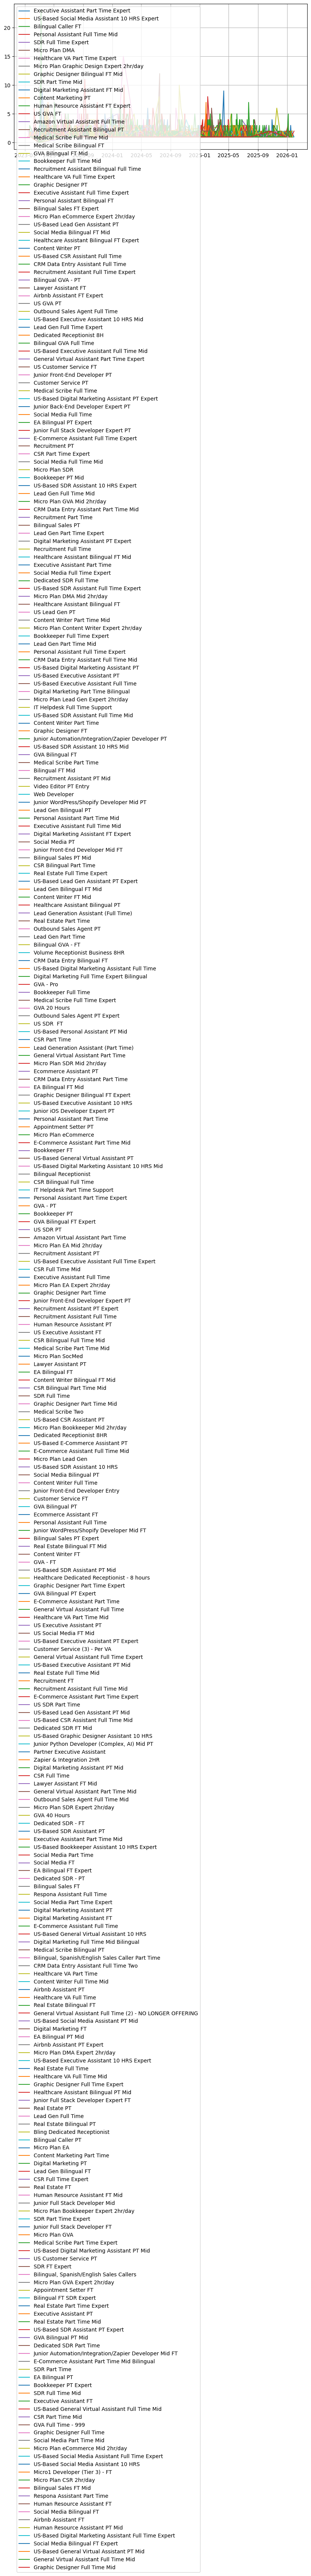

In [88]:
# products are to many to plot them in a data visualization
print(product_ts_df.head(10))

# Get unique products (Polars-safe)
product_set = product_ts_df.select("Product").unique().to_series().to_list()

print(product_ts_df.select("Product").unique().count().item())

plt.figure(figsize=(10, 5))

for product in product_set:
    selected_data = product_ts_df.filter(
        pl.col("Product") == product
    )

    plt.plot(
        selected_data["Start Date"],
        selected_data["Actual HC"],
        label=product
    )

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the time series
plt.figure(figsize=(10, 5))

# --- Detect largest spikes in historical data ---
x = product_ts_df['product'].to_pandas()
y = product_ts_df['Total_HC'].to_numpy()

# --- Plot historical ---
plt.plot(x, y, label="Historical Total HC by Product", color="blue")

# Find local peaks
peaks, _ = find_peaks(y)

# Keep only major spikes (top 10%)
threshold = np.percentile(y, 90)
major_peaks = [p for p in peaks if y[p] >= threshold]

# --- Add data labels for major spikes ---
for i in major_peaks:
    plt.text(
        x[i],
        y[i],
        f"{int(y[i])}",
        fontsize=8,
        color="black",
        ha="center",
        va="bottom"
    )

# --- Format x-axis to YYYY-MM ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.title("Historical Total HC by Product - Staffed and Boarded JRFs")
plt.xlabel("Monthly")
plt.xticks(rotation=45, ha='right')  # 'ha' means horizontal alignment
plt.ylabel("Total HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# Group Product, Week Start Date, Resource Required

product_summary_week = (
    data.group_by(["product", "week_yyyy_start_date","mm_yyyy_start_date"])
        .agg([
            pl.sum("resource_required").alias("Total_HC")
        ])
        .drop_nulls()
        .sort(by=["week_yyyy_start_date", "product"],
            descending=[True, False])  # <-- sorting here
     
)

product_summary_week = product_summary_week.with_columns(
    pl.col("week_yyyy_start_date").cast(pl.Date)
)

print(product_summary_week.head(10))

shape: (10, 4)
┌─────────────────────────────────┬──────────────────────┬────────────────────┬──────────┐
│ product                         ┆ week_yyyy_start_date ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---                             ┆ ---                  ┆ ---                ┆ ---      │
│ str                             ┆ date                 ┆ str                ┆ i64      │
╞═════════════════════════════════╪══════════════════════╪════════════════════╪══════════╡
│ CSR Full Time                   ┆ 2026-01-26           ┆ 2026-01            ┆ 2        │
│ Dedicated SDR Full Time         ┆ 2026-01-26           ┆ 2026-01            ┆ 1        │
│ Digital Marketing Assistant PT… ┆ 2026-01-26           ┆ 2026-01            ┆ 3        │
│ Executive Assistant Full Time … ┆ 2026-01-26           ┆ 2026-01            ┆ 1        │
│ Executive Assistant Part Time   ┆ 2026-01-26           ┆ 2026-01            ┆ 1        │
│ Executive Assistant Part Time … ┆ 2026-01-26           ┆ 2026-01         

In [74]:
# Select and rename columns for export
product_summary_week_ts_df = product_summary_week.select([
    pl.col("product").alias("Product"),
    pl.col("week_yyyy_start_date").alias("Week Start Date"),
    pl.col("Total_HC").alias("Actual HC")
])

# Save to CSV
product_summary_week_ts_df.write_csv("jrf_product_weekly_time_series_output.csv")

print("Time Series saved to 'jrf_product_weekly_time_series_output.csv'")

Time Series saved to 'jrf_product_weekly_time_series_output.csv'


In [79]:
# Group Product, Month Start Date, Resource Required

product_summary_month = (
    data.group_by(["product", "mm_yyyy_start_date"])
        .agg([
            pl.sum("resource_required").alias("Total_HC")
        ])
        .drop_nulls()
        .sort(
            by=["mm_yyyy_start_date", "product"],
            descending=[True, False]
        )
)

print(product_summary_month.head(10))

shape: (10, 3)
┌─────────────────────────────────┬────────────────────┬──────────┐
│ product                         ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---                             ┆ ---                ┆ ---      │
│ str                             ┆ str                ┆ i64      │
╞═════════════════════════════════╪════════════════════╪══════════╡
│ Bookkeeper FT                   ┆ 2026-01            ┆ 1        │
│ Bookkeeper Full Time Expert     ┆ 2026-01            ┆ 1        │
│ Bookkeeper Full Time Mid        ┆ 2026-01            ┆ 1        │
│ Bookkeeper PT Mid               ┆ 2026-01            ┆ 1        │
│ CRM Data Entry Assistant Full … ┆ 2026-01            ┆ 1        │
│ CSR Bilingual Full Time         ┆ 2026-01            ┆ 2        │
│ CSR Full Time                   ┆ 2026-01            ┆ 11       │
│ CSR Full Time Mid               ┆ 2026-01            ┆ 3        │
│ CSR Part Time                   ┆ 2026-01            ┆ 1        │
│ CSR Part Time Mid              

In [80]:
# Export to csv
product_summary_month_ts_df = product_summary_month.select([
    pl.col("product").alias("Product"),
    pl.col("mm_yyyy_start_date").alias("Month Start Date"),
    pl.col("Total_HC").alias("Actual HC")
])

# Save to CSV
product_summary_month_ts_df.write_csv("jrf_product_monthly_time_series_output.csv")

print("Time Series saved to 'jrf_product_monthly_time_series_output.csv'")

Time Series saved to 'jrf_product_monthly_time_series_output.csv'


In [50]:
# --- Ensure 'start_date' is parsed as Datetime safely ---
if product_summary.schema['start_date'] == pl.Utf8:
    # Parse day-month-year format like "01-11-2023"
    product_summary = product_summary.with_columns(
        pl.col('start_date')
        .str.strptime(pl.Datetime, "%m-%d-%Y", strict=False)
    )
else:
    # Already datetime-like — ensure consistent dtype
    product_summary = product_summary.with_columns(
        pl.col('start_date').cast(pl.Datetime)
    )

# Sort by date
product_summary = product_summary.sort('product','start_date')

# Display sample data
print(product_summary.head(10))

shape: (10, 5)
┌─────────────────────────────────┬─────────────────────┬──────────────────────┬────────────────────┬──────────┐
│ product                         ┆ start_date          ┆ week_yyyy_start_date ┆ mm_yyyy_start_date ┆ Total_HC │
│ ---                             ┆ ---                 ┆ ---                  ┆ ---                ┆ ---      │
│ str                             ┆ datetime[μs]        ┆ datetime[μs]         ┆ str                ┆ i64      │
╞═════════════════════════════════╪═════════════════════╪══════════════════════╪════════════════════╪══════════╡
│ Airbnb Assistant FT             ┆ 2025-04-28 00:00:00 ┆ 2025-04-28 00:00:00  ┆ 2025-04            ┆ 1        │
│ Airbnb Assistant FT             ┆ 2025-05-01 00:00:00 ┆ 2025-04-28 00:00:00  ┆ 2025-05            ┆ 2        │
│ Airbnb Assistant FT             ┆ 2025-05-02 00:00:00 ┆ 2025-04-28 00:00:00  ┆ 2025-05            ┆ 1        │
│ Airbnb Assistant FT             ┆ 2025-10-03 00:00:00 ┆ 2025-09-29 00:00:00  ┆ 